# **Movie Recommendation System**
---------------
## **Context**
---------------

Online streaming platforms like **Netflix** have plenty of movies in their repository and if we can build a **Recommendation System** to recommend **relevant movies** to users, based on their **historical interactions**, this would **improve customer satisfaction** and hence, it will also improve the revenue of the platform. The techniques that we will learn here will not only be limited to movies, it can be any item for which you want to build a recommendation system.

-----------------
## **Objective**
-----------------

In this project I will be building various types of recommendation systems: 
- Knowledge/Rank based recommendation system
- Similarity-Based Collaborative filtering
- Matrix Factorization Based Collaborative Filtering

I'm going to use the **ratings** dataset. 

-----------------
## **Dataset**
-----------------

The **ratings** dataset contains the following attributes: 
- userId
- movieId
- rating
- timestamp

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this case study.

Let's start by mounting the Google drive on Colab.

In [ ]:
# uncomment if you are using google colab

#from google.colab import drive
#drive.mount('/content/drive')

**Installing surprise library**

In [1]:
# Installing surprise library, only do it for first time
!pip install surprise

  Using cached surprise-0.1-py2.py3-none-any.whl (1.8 kB)


## **Importing the necessary libraries and overview of the dataset**

In [2]:
# Used to ignore the warning given as output of the code
import warnings                                 
warnings.filterwarnings('ignore')

# Basic libraries of python for numeric and dataframe computations
import numpy as np                              
import pandas as pd

# Basic library for data visualization
import matplotlib.pyplot as plt     

# Slightly advanced library for data visualization            
import seaborn as sns                           

# A dictionary output that does not raise a key error
from collections import defaultdict             

# A performance metrics in surprise
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For model tuning model hyper-parameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test dataset
from surprise.model_selection import train_test_split

# For implementing similarity based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# For implementing cross validation
from surprise.model_selection import KFold

### **Loading the data**

In [3]:
# Import the dataset
rating = pd.read_csv('ratings.csv')
#rating = pd.read_csv('/content/drive/MyDrive/ratings.csv') # Uncomment this line code  and comment above line of code if you are using google colab.

Let's check the **info** of the data

In [4]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


- There are **100,004 observations** and **4 columns** in the data
- All the columns are of **numeric data type**
- The data type of the timestamp column is int64 which is not correct. We can convert this to DateTime format but **we don't need timestamp for our analysis**. Hence, **we can drop this column**

In [5]:
# Dropping timestamp column
rating = rating.drop(['timestamp'], axis=1)

## **Exploring the dataset**

Let's explore the dataset and answer some basic data-related questions:

In [6]:
# Printing the top 5 rows of the dataset Hint: use .head()

rating.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


### **Describe the distribution of ratings**



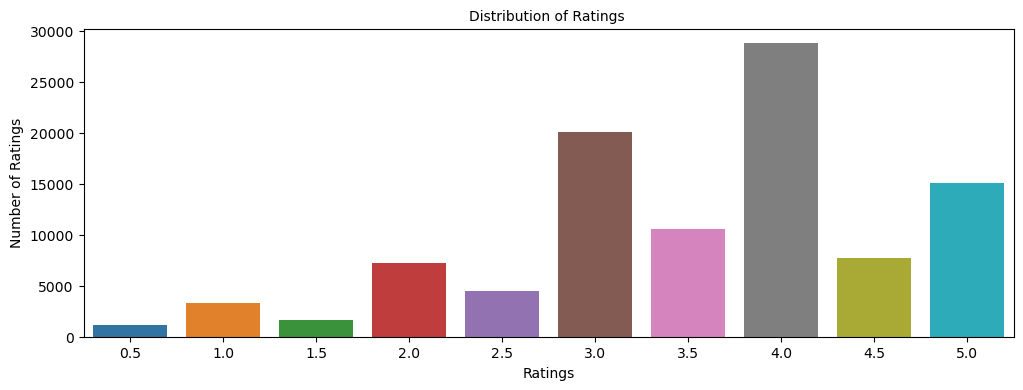

In [7]:
# Display histogram of the movie ratings
plt.figure(figsize = (12, 4))

sns.countplot(x='rating', data=rating)

plt.tick_params(labelsize = 10)
plt.title("Distribution of Ratings ", fontsize = 10)
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Number of Ratings", fontsize = 10)
plt.show()

- The movie ratings distribution has 10 bins (imagine using stars, movies can get 0.5 star up to 5 stars)

- The rating frequency distribution shows that the **highest count** of **rating** is '4' with 28K+ ratings, rating '3' ~20K comes in second, and rating '5' ~15K comes in third.

- The ratings distribution seems to be left skewed. It could reflect that the majority of viewers like what they're watching.

In [8]:
# Finding number of unique users
rating['userId'].nunique()

671

- There are **671 users** in the dataset.

In [9]:
# Finding number of unique movies
rating['movieId'].nunique()

9066

- There are **9,066** movies in the dataset.

### **Investigating If there is a movie in which the same user interacted with it more than once? (1 Mark)**

In [10]:
# Finding the number of user movie interactions
rating.groupby(['userId', 'movieId']).count()

rating
userId movieId        
1      31            1
       1029          1
       1061          1
       1129          1
       1172          1
...                ...
671    6268          1
       6269          1
       6365          1
       6385          1
       6565          1

[100004 rows x 1 columns]

In [11]:
# Finding the sum of user movie grouped interactions
rating.groupby(['userId', 'movieId']).count()['rating'].sum()

100004

- The sum of grouped user-movie pair interactions is equal to the total number of observations. This implies that there is 1 unique interaction per user-movie pair, i.e. **a user did not rate the same movie more than once**.

### ** Which is the most interacted movie in the dataset?**

In [12]:
# Finding the total number of times a movie interaction took place.
rating['movieId'].value_counts()

356       341
296       324
318       311
593       304
260       291
         ... 
98604       1
103659      1
104419      1
115927      1
6425        1
Name: movieId, Length: 9066, dtype: int64

- Movie with id 356, **is the most interacted with movie**, where **341 users** have rated this movie.

- This implies that there is a possibility of 671-341=330 more interactions for this movie, as we have 671 unique users in our dataset. A recommendation system can predict who is most likely out of those 330 users is most likely to interact with the movie.

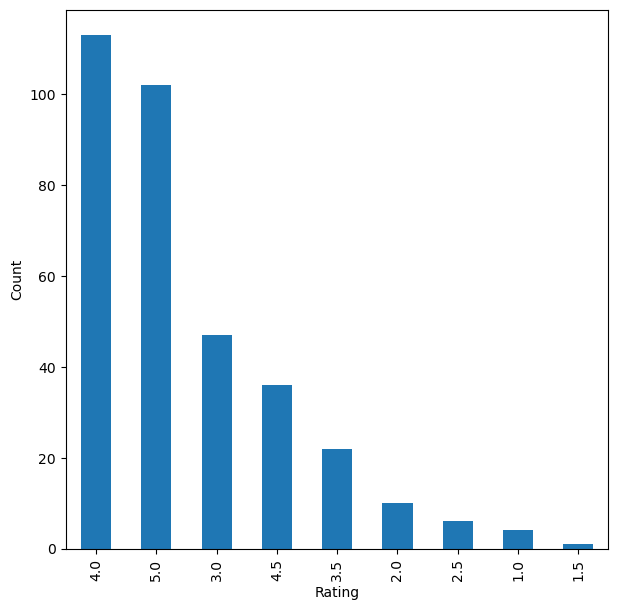

In [13]:
# Plotting distributions of ratings for 341 interactions with movieid 356 
plt.figure(figsize=(7,7))

rating[rating['movieId'] == 356]['rating'].value_counts().plot(kind='bar')

plt.xlabel('Rating')

plt.ylabel('Count')

plt.show()

- Movie with id 356 seems to be really liked by its viewing users, as the majority ~70% have rated this movie '4', about ~140 users and ~100 users gave it a rating of '5', .

- The 3 next user groups have opted to rate this movie 3,4.5 and 3.5 consecutively, ~100 users in total.

- Very small number of users gave this movie a rating of 2.5 or lower, and so little number disliked it.

### **Which user interacted the most with any movie in the dataset?**

In [14]:
# Finding the total number of times a movie interaction took place.
rating['userId'].value_counts()

547    2391
564    1868
624    1735
15     1700
73     1610
       ... 
296      20
289      20
249      20
221      20
1        20
Name: userId, Length: 671, dtype: int64

- User with id 547, **has interacted the most with movies**, where the user has interacted with **2,391 movies**.

- This implies that there is a possibility of 9066-2391=6675 more interactions for this user, as we have 9066 unique movies in our dataset. A recommendation system can predict which movies out of those 6675 are most likely to be watched by this user.

- This user seems to be a special case, an outlier. Likes watching movies, 500+ more than second person ranked.

### **What is the distribution of the user-movie interactions in this dataset?**

In [15]:
# Finding user-movie interactions distribution
count_interactions = rating.groupby('userId').count()['movieId']
count_interactions

userId
1       20
2       76
3       51
4      204
5      100
      ... 
667     68
668     20
669     37
670     31
671    115
Name: movieId, Length: 671, dtype: int64

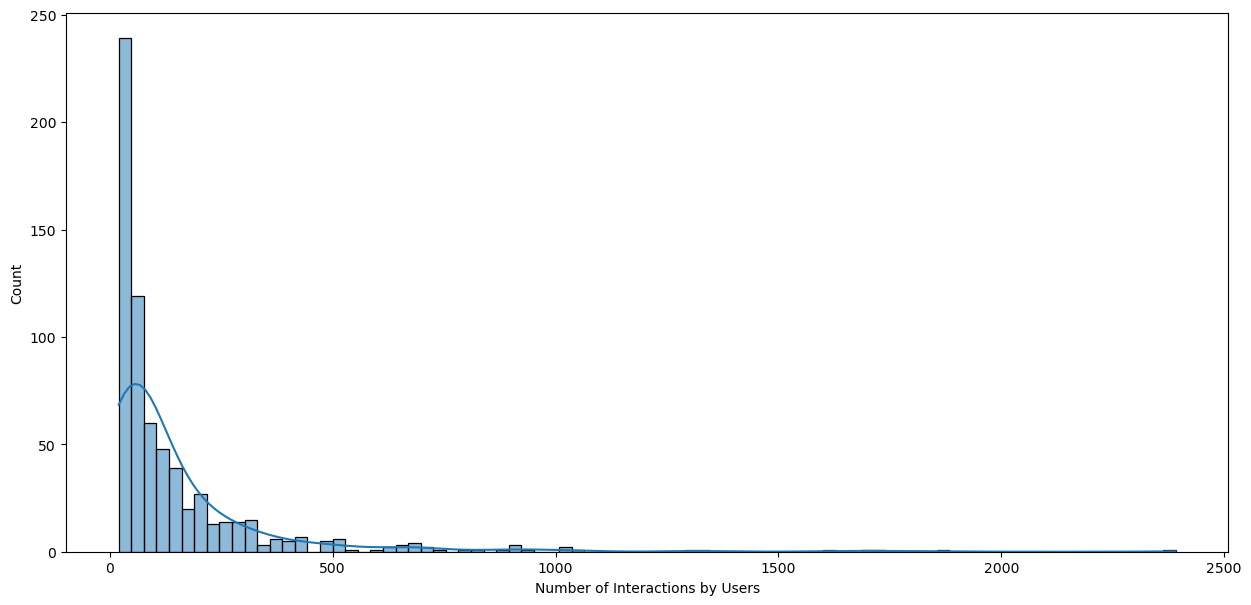

In [16]:
# Plotting user-movie interactions distribution

plt.figure(figsize=(15,7))

sns.histplot(count_interactions, kde=True)

plt.xlabel('Number of Interactions by Users')

plt.show()

- The distribution of number of interactions by users is highly skewed to the right.

- The majority of users interacted with <300 movies.

#### As we have now explored the data, let's start building Recommendation systems

## **Creating Rank-Based Recommendation System**

### **Model 1: Rank-Based Recommendation System**

Rank-based recommendation systems provide recommendations based on the most popular items. This kind of recommendation system is useful when we have **cold start** problems.

To build the rank-based recommendation system, we take **average** of all the ratings provided to each movie and then rank them based on their average rating.

In [17]:
# calc avg and total interactions per movie

# Calculating average ratings
average_rating = rating.groupby('movieId').mean()['rating']

# Calculating the count of ratings
count_rating = rating.groupby('movieId').count()['rating']

# Making a dataframe with the count and average of ratings
final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})

In [18]:
final_rating.head()

,avg_rating,rating_count
movieId,,
1,3.872470,247
2,3.401869,107
3,3.161017,59
4,2.384615,13
5,3.267857,56


Now, let's create a function to find the **top n movies** for a recommendation based on the average ratings of movies. We can also add a **threshold for a minimum number of interactions** for a movie to be considered for recommendation. 

In [19]:
def top_n_movies(data, n, min_interaction=100):
    
    #Finding movies with minimum number of interactions
    recommendations = data[data['rating_count'] >= min_interaction]
    
    #Sorting values w.r.t average rating 
    recommendations = recommendations.sort_values(by='avg_rating', ascending=False)
    
    return recommendations.index[:n]

We can **use this function with different n's and minimum interactions** to get movies to recommend

#### **Recommending top 5 movies with 50 minimum interactions based on popularity**

In [20]:
# Get top 5 movies by avg rating per 50 minimum interaction
list(top_n_movies(final_rating, 5, 50))

[858, 318, 969, 913, 1221]

#### **Recommending top 5 movies with 100 minimum interactions based on popularity**

In [21]:
# Get top 5 movies by avg rating per 100 minimum interaction
list(top_n_movies(final_rating, 5, 100))

[858, 318, 1221, 50, 527]

#### **Recommending top 5 movies with 200 minimum interactions based on popularity**

In [22]:
# Get top 5 movies by avg rating per 200 minimum interaction
list(top_n_movies(final_rating, 5, 200))

[858, 318, 50, 527, 608]

Now that we have seen **how to apply the Rank-Based Recommendation System**, let's apply the **Collaborative Filtering Based Recommendation Systems**.

## **Model 2: User based Collaborative Filtering Recommendation System**

![collaborative_filtering.PNG](https://raw.githubusercontent.com/GL-ACADOPS/RS-IMAGES/main/collaborative_filtering.PNG)

In the above **interactions matrix**, out of users B and C, which user is most likely to interact with the movie, "The Terminal"?

In this type of recommendation system we only need user item interaction data to build a collaborative recommendation system. For example - 
<ol>
    <li><b>Ratings</b> provided by users. For example - ratings of books on goodread, movie ratings on imdb etc</li>
    <li><b>Likes</b> of users on different facebook posts, likes on youtube videos</li>
    <li><b>Use/buying</b> of a product by users. For example - buying different items on e-commerce sites</li>
    <li><b>Reading</b> of articles by readers on various blogs</li>
</ol>

**Types of Collaborative Filtering**

- Similarity/Neighborhood based

 * User-User Similarity Based  
 * Item-Item similarity based

- Model based

#### **Building Similarity/Neighborhood based Collaborative Filtering**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

#### **Making the dataset into surprise dataset and splitting it into train and test set**

In [23]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(0, 5))

# Loading the rating dataset
data = Dataset.load_from_df(rating[['userId', 'movieId', 'rating']], reader)

# Splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

#### **Build the first baseline similarity based recommendation system using cosine similarity and KNN**

In [24]:
# user-user-similarity-based-KNN-baseline
sim_options = {'name': 'cosine',
               'user_based': True}
# Defining Nearest neighbour algorithm
algo_knn_user = KNNBasic(sim_options=sim_options,verbose=False)

# Train the algorithm on the trainset or fitting the model on train dataset 
algo_knn_user.fit(trainset)

# Predict ratings for the testset
predictions = algo_knn_user.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 0.9925


0.9924509041520163

### **What is the RMSE for baseline user based collaborative filtering recommendation system?**

- As we can see from the above results, the **baseline KNN user-user similarity** model has `RMSE=0.99` on the test set.

- We should try to tune hyperparameters of this algorithm using `GridSearchCV`.

### **What is the Predicted  rating for a user with userId=4 and for movieId=10 and movieId=3?**

Let's us now predict rating for a user with `userId=4` and for `movieId=10`

In [25]:
# predict rating givin actual
algo_knn_user.predict(4, 10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 3.62   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.6244912065910952, details={'actual_k': 40, 'was_impossible': False})

- As we can see above the actual rating for this user-movie pair is 4 and predicted rating is 3.62 by this similarity based baseline model.

Let's predict the rating for the same `userId=4` but for a movie which this user has not interacted before i.e. `movieId=3`

In [26]:
# predict rating for unknown
algo_knn_user.predict(4, 3, verbose=True)

user: 4          item: 3          r_ui = None   est = 3.20   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.202703552548654, details={'actual_k': 40, 'was_impossible': False})

- As we can see the estimated rating for this user-movie pair is 3.20 based on this similarity based baseline model.

### **Improving user-user similarity based recommendation system by tuning its hyper-parameters**

Below we will be tuning hyper-parmeters for the `KNNBasic` algorithms.

### **Performing hyperparameter tuning for the baseline user based collaborative filtering recommendation system and find the RMSE for tuned user based collaborative filtering recommendation system?**

In [27]:
# user-user-similarity-based-KNN-tunned

# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}
              }

# Performing 3-fold cross validation to tune the hyperparameters
grid_obj = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting the data
grid_obj.fit(data)

# Best RMSE score
print(grid_obj.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(grid_obj.best_params['rmse'])

0.9638651385473992
{'k': 20, 'min_k': 3, 'sim_options': {'name': 'msd', 'user_based': True}}


The **optimal values** for each of those hyperparameters are shown above.

Below we are analysing evaluation metrics - RMSE and MAE at each and every split to analyze the impact of each value of hyperparameters

In [28]:
results_df = pd.DataFrame.from_dict(grid_obj.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_min_k,param_sim_options
0,0.964736,0.965808,0.961051,0.963865,0.002038,1,0.742911,0.741916,0.738637,0.741155,0.001826,1,0.120367,0.015334,2.151985,0.032840,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'msd', 'user_based': True}"
1,0.993364,0.995129,0.990447,0.992980,0.001931,13,0.770303,0.768020,0.765474,0.767933,0.001972,12,0.618220,0.024920,2.204508,0.039157,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'cosine', 'user_based': True}"
2,0.970299,0.968666,0.965600,0.968188,0.001948,3,0.747144,0.744438,0.742464,0.744682,0.001918,3,0.160806,0.005048,2.197993,0.047962,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'msd', 'user_based': True}"
3,0.997625,0.996392,0.992966,0.995661,0.001971,15,0.773196,0.769413,0.767645,0.770085,0.002315,15,0.611574,0.008076,2.230960,0.020516,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'cosine', 'user_based': True}"
4,0.976552,0.975509,0.972699,0.974920,0.001627,7,0.752137,0.749757,0.747604,0.749833,0.001851,6,0.187103,0.004245,2.344550,0.029391,"{'k': 20, 'min_k': 9, 'sim_options': {'name': ...",20,9,"{'name': 'msd', 'user_based': True}"


Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.



In [29]:
# user-user-similarity-based-KNN-tunned build
sim_options = {'name': 'msd',
               'user_based': True}
# Using the optimal similarity measure for user-user based collaborative filtering
# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized_user = KNNBasic(sim_options=sim_options, k=20, min_k=3,verbose=False)

# Training the algorithm on the trainset
similarity_algo_optimized_user.fit(trainset)

# Predicting ratings for the testset
predictions = similarity_algo_optimized_user.test(testset)

# Computing RMSE on testset
accuracy.rmse(predictions)

RMSE: 0.9571


0.9571445417153293

- We can see from above that after tuning the hyperparameters, `RMSE=0.95` for the test set, which has reduced to **0.95** from **0.99**. We can say that we have been able to improve the model after hyperparameter tunning.

### **What is the Predicted rating for a user with userId =4 and for movieId= 10 and movieId=3 using tuned user based collaborative filtering?**

Let's us now predict rating for a user with `userId=4` and for `movieId=10` with the optimized model

In [30]:
# predict rating givin actual
similarity_algo_optimized_user.predict(4,10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 3.74   {'actual_k': 20, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.740028692988536, details={'actual_k': 20, 'was_impossible': False})

- If we compare the above predicted rating, we can see the baseline model predicted rating as `3.62` and the optimized model predicted the rating as `3.74`.

Below we are predicting rating for the same `userId=4` but for a movie which this user has not interacted before i.e. `movieId=3`, by using the optimized model as shown below - 

In [31]:
# predict rating for unknown
similarity_algo_optimized_user.predict(4,3, verbose=True)

user: 4          item: 3          r_ui = None   est = 3.72   {'actual_k': 20, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.7228745701935386, details={'actual_k': 20, 'was_impossible': False})

- If we compare the above predicted rating, we can see the baseline model predicted rating as `3.20` and the optimized model predicted the rating as `3.72`.

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out the similar users to a given user or its nearest neighbors based on this KNNBasic algorithm. Below we are finding 5 most similar user to the `userId=4` based on the `msd` distance metric

In [32]:
# Get nearest neighbors
similarity_algo_optimized_user.get_neighbors(4, k=5)

[665, 417, 647, 654, 260]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are - 

- data: a rating dataset
- user_id: an user id against which we want the recommendations
- top_n: the number of movies we want to recommend
- algo: the algorithm we want to use to predict the ratings

In [33]:
def get_recommendations(data, user_id, top_n, algo):
    
    # Creating an empty list to store the recommended movie ids
    recommendations = []
    
    # Creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot(index='userId', columns='movieId', values='rating')
    
    # Extracting those movie ids which the user_id has not interacted yet
    non_interacted_movies = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    # Looping through each of the movie id which user_id has not interacted yet
    for item_id in non_interacted_movies:
        
        # Predicting the ratings for those non interacted movie ids by this user
        est = algo.predict(user_id, item_id).est
        
        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return recommendations[:top_n] # returing top n highest predicted rating movies for this user

#### **Predicted top 5 movies for userId=4 with similarity based recommendation system**

In [34]:
# predict top 5 for user x, using user based similarity
recommendations = get_recommendations(rating,4,5,similarity_algo_optimized_user)

### **The Predicted top 5 movies for userId=4 with similarity based recommendation system**

In [35]:
recommendations

[(309, 5),
 (3038, 5),
 (6273, 4.928202652354184),
 (98491, 4.863224466679252),
 (2721, 4.845513973527148)]

## **Model 3: Item based Collaborative Filtering Recommendation System**

In [36]:
# item-item-similarity-based-KNN-baseline

# Definfing similarity measure
sim_options = {'name': 'cosine',
               'user_based': False}

# Defining Nearest neighbour algorithm
algo_knn_item = KNNBasic(sim_options=sim_options,verbose=False)

# Train the algorithm on the trainset or fitting the model on train dataset 
algo_knn_item.fit(trainset)

# Predict ratings for the testset
predictions = algo_knn_item.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 1.0032


1.003221450633729

- As we can see from above, the baseline model has `RMSE=1.00` on test set, we will try to improve this number later by using `GridSearchCV` tunning different hyperparameters of this algorithm.


Let's us now predict rating for an user with `userId=4` and for `movieId=10`

### **What is the Predicted  rating for a user with userId =4 and for movieId= 10 and movieId=3?**

In [37]:
# predict rating givin actual
algo_knn_item.predict(4,10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 4.37   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=4.373794871885004, details={'actual_k': 40, 'was_impossible': False})

- As we can see the actual rating for this user-movie pair is 4 and the predicted rating is 4.37 by this item similarity based baseline model.


Let's predict  the rating for the same `userId=4` but for a movie which this user has not interacted before i.e. `movieId=3`

In [38]:
# predict rating for unknown
algo_knn_item.predict(4,3, verbose=True)

user: 4          item: 3          r_ui = None   est = 4.07   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=4.071601862880049, details={'actual_k': 40, 'was_impossible': False})

- As we can see the estimated rating for this user-movie pair is 4.07 based on this item similarity based baseline model.


### **Performing hyperparameter tuning for the baseline item based collaborative filtering recommendation system and find the RMSE for tuned item based collaborative filtering recommendation system?**

In [39]:
# item-item-similarity-based-KNN-tunned

# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30,40], 'min_k': [3,6,9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}
              }

# Performing 3-fold cross validation to tune the hyperparameters
grid_obj = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting the data
grid_obj.fit(data)

# Best RMSE score
print(grid_obj.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(grid_obj.best_params['rmse'])

0.9403164828379178
{'k': 40, 'min_k': 3, 'sim_options': {'name': 'msd', 'user_based': False}}


The **optimal values** for each of those hyperparameters are shown above

Below we are analysing evaluation metrics - RMSE and MAE at each and every split to analyze the impact of each value of hyperparameters

In [40]:
results_df = pd.DataFrame.from_dict(grid_obj.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_min_k,param_sim_options
0,0.950923,0.954582,0.948254,0.951253,0.002594,7,0.734348,0.736096,0.733126,0.734523,0.001219,7,48.658611,4.308150,30.475851,6.983073,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'msd', 'user_based': False}"
1,1.015518,1.016059,1.010335,1.013971,0.002580,16,0.792555,0.790867,0.789764,0.791062,0.001148,16,127.587812,4.004448,20.585379,1.009157,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'cosine', 'user_based': False}"
2,0.951251,0.954844,0.948728,0.951608,0.002510,8,0.734607,0.736372,0.733500,0.734826,0.001183,8,42.124730,1.926249,14.167216,0.559977,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'msd', 'user_based': False}"
3,1.015887,1.016418,1.010800,1.014368,0.002533,17,0.792864,0.791155,0.790094,0.791371,0.001141,17,106.107245,1.871320,33.246737,0.975926,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'cosine', 'user_based': False}"
4,0.951906,0.955143,0.948648,0.951899,0.002652,9,0.735323,0.736745,0.733600,0.735223,0.001286,9,7.821459,0.621098,12.355477,0.140999,"{'k': 20, 'min_k': 9, 'sim_options': {'name': ...",20,9,"{'name': 'msd', 'user_based': False}"


Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

In [41]:
# item-item-similarity-based-KNN-tunned build

# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized_item = KNNBasic(sim_options={'name': 'msd', 'user_based': False}, k=40, min_k=3,verbose=False)

# Training the algorithm on the trainset
similarity_algo_optimized_item.fit(trainset)

# Predicting ratings for the testset
predictions = similarity_algo_optimized_item.test(testset)

# Computing RMSE on testset
accuracy.rmse(predictions)

RMSE: 0.9433


0.9433184999641279

- We can see from above that after tuning hyperparameters, `RMSE=0.94` for the test set, which has reduced to **0.94** from **1.00**. We can say that we have been able to improve the model after hyperparameter tunning.

- The tunned item based similarity model has a slightly better `RMSE` score than the user based similarity model, **0.94** and **0.95** respectively.

### **What is the Predicted rating for an item with userId =4 and for movieId= 10 and movieId=3 using tuned item based collaborative filtering?**

Let's us now predict rating for a user with `userId=4` and for `movieId=10` with the optimized model as shown below

In [42]:
# predict rating givin actual
similarity_algo_optimized_item.predict(4,10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 4.26   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=4.255054787154994, details={'actual_k': 40, 'was_impossible': False})

- If we compare the above predicted rating, we can see the baseline model predicted rating as `4.37` and the optimized model predicted the rating as `4.26`.

Let's predict the rating for the same `userId=4` but for a movie which this user has not interacted before i.e. `movieId=3`, by using the optimized model:

In [43]:
# predict rating for unknown
similarity_algo_optimized_item.predict(4, 3, verbose=True)

user: 4          item: 3          r_ui = None   est = 3.87   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.865175609312417, details={'actual_k': 40, 'was_impossible': False})

- If we compare the above predicted rating, we can see the baseline model predicted rating as `4.07` and the optimized model predicted the rating as `3.87`.

### **Identifying similar items to a given item (nearest neighbors)**
We can also find out the similar items to a given item or its nearest neighbors based on this KNNBasic algorithm. Below we are finding 5 most similar items to the `movieId=3` based on the `msd` distance metric

In [44]:
# Get nearest neighbors
similarity_algo_optimized_item.get_neighbors(3, k=5)

[31, 37, 42, 48, 73]

#### **Predicted top 5 movies for userId=4 with similarity based recommendation system**

In [45]:
# predict top 5 for user x, using item based similarity
recommendations = get_recommendations(rating, 4, 5, similarity_algo_optimized_item)

### **What are the top 5 movies for userId=4 with similarity based recommendation system**

In [46]:
recommendations

[(84, 5), (1040, 5), (2481, 5), (3078, 5), (3116, 5)]

## **Model 4: Based Collaborative Filtering - Matrix Factorization using SVD**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### **Singular Value Decomposition (SVD)**

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

**SVD decomposes this above matrix into three separate matrices:**
- U matrix
- Sigma matrix
- V transpose matrix

### **Build a baseline matrix factorization recommendation system**

In [47]:
# SVD-baseline

# Using SVD matrix factorization
algo_svd = SVD()

# Training the algorithm on the trainset
algo_svd.fit(trainset)

# Predicting ratings for the testset
predictions = algo_svd.test(testset)

# Computing RMSE on the testset
accuracy.rmse(predictions)

RMSE: 0.9045


0.904484403513331

### **What is the RMSE for baseline SVD based collaborative filtering recommendation system?**

- We can see that the baseline `RMSE` for matrix factorization model on the testset (which is `0.90`) is lower as compared to the RMSE of the best peforming baseline similarity based recommendation system (which is `0.99`) and it is even better than the RMSE for the best performing optimized similarity based recommendation system (which is `0.94`).

### **What is the Predicted  rating for an user with userId =4 and for movieId= 10 and movieId=3?**

Let's us now predict rating for a user with `userId=4` and for `movieId=10`

In [48]:
# predict rating givin actual
algo_svd.predict(4, 10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 4.10   {'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=4.101167386664336, details={'was_impossible': False})

- As we can see the actual rating for this user-item pair is 4 and predicted rating is **4.10** by this matrix factorization based baseline model. This is the `best performing prediction` in all models. We will try to get an even better prediction by tuning the hyperparameters of the model using GridSearchCV.

Let's predict the rating for the same `userId=4` but for a movie which this user has not interacted before i.e. `movieId=3`:

In [49]:
# predict rating for unknown
algo_svd.predict(4, 3, verbose=True)

user: 4          item: 3          r_ui = None   est = 4.02   {'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=4.021660391501704, details={'was_impossible': False})

- We can see that estimated rating for this user-movie pair is **4.02** based on this matrix factorization based baseline model.

### **Improving matrix factorization based recommendation system by tuning its hyper-parameters**

### **Performing hyperparameter tuning for the baseline SVD based collaborative filtering recommendation system and find the RMSE for tuned SVD based collaborative filtering recommendation system?**

In [50]:
# SVD-tunned

# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross validation
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.8943207245550262
{'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.2}


The **optimal values** for each of those hyperparameters are shown above.

Below we are analysing evaluation metrics - RMSE and MAE at each and every split to analyze the impact of each value of hyperparameters

In [51]:
results_df = pd.DataFrame.from_dict(gs.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_epochs,param_lr_all,param_reg_all
0,0.941321,0.951652,0.936535,0.943169,0.006309,25,0.738103,0.743756,0.733393,0.738417,0.004236,25,3.346242,0.273338,0.357303,0.045000,"{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.2}",10,0.001,0.2
1,0.945595,0.956508,0.941126,0.947743,0.006461,26,0.742816,0.748571,0.739580,0.743656,0.003718,26,3.434635,0.304490,0.370789,0.044347,"{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.4}",10,0.001,0.4
2,0.950455,0.961853,0.946868,0.953059,0.006389,27,0.748226,0.754727,0.745489,0.749481,0.003874,27,3.367529,0.324978,0.431842,0.143167,"{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.6}",10,0.001,0.6
3,0.904626,0.914879,0.901482,0.906996,0.005720,11,0.701662,0.707252,0.698730,0.702548,0.003535,9,3.236170,0.158817,0.425289,0.157688,"{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.2}",10,0.005,0.2
4,0.911373,0.921870,0.908674,0.913972,0.005692,15,0.709285,0.714442,0.706759,0.710162,0.003197,15,3.557955,0.549561,0.428092,0.056471,"{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}",10,0.005,0.4


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [52]:
# SVD-tunned build

# Building the optimized SVD model using optimal hyperparameter search
svd_algo_optimized = SVD(n_epochs=30, lr_all=0.01, reg_all=0.2)

# Training the algorithm on the trainset
svd_algo_optimized.fit(trainset)

# Predicting ratings for the testset
predictions = svd_algo_optimized.test(testset)

# Computing RMSE
accuracy.rmse(predictions)

RMSE: 0.8953


0.8952946469201709

### **What is the Predicted rating for a user with userId =4 and for movieId= 10 and movieId=3 using SVD based collaborative filtering?**

Let's us now predict rating for a user with `userId=4` and for `movieId=10` with the optimized model

In [53]:
# predict rating givin actual
svd_algo_optimized.predict(4, 10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 3.99   {'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.9869882700358845, details={'was_impossible': False})

- As we can see the actual rating for this user-item pair is 4 and predicted rating is **3.99** by this matrix factorization based tunned model. This is the `best performing prediction` in all models.

Let's predict the rating for the same `userId=4` but for a movie which this user has not interacted before i.e. `movieId=3`:

In [54]:
# predict rating for unknown
svd_algo_optimized.predict(4, 3, verbose=True)

user: 4          item: 3          r_ui = None   est = 3.64   {'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.641063031838499, details={'was_impossible': False})

### **Predict the top 5 movies for userId=4 with SVD based recommendation system?**

In [55]:
# predict top 5 for user x, using matrix factorization
get_recommendations(rating, 4, 5, svd_algo_optimized)

[(1948, 4.95028914128293),
 (926, 4.948375072957126),
 (1192, 4.943763301776185),
 (116, 4.936122292328054),
 (5114, 4.931208350166152)]

### **Predicting ratings for already interacted movies** 

Below we are comparing the rating predictions of users for those movies which has been already watched by a user. This will help us to understand how well are predictions are as compared to the actual ratings provided by users

In [56]:
def predict_already_interacted_ratings(data, user_id, algo):
    
    # Creating an empty list to store the recommended movie ids
    recommendations = []
    
    # Creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot(index='userId', columns='movieId', values='rating')
    
    # Extracting those movie ids which the user_id has interacted already
    interacted_movies = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].notnull()].index.tolist()
    
    # Looping through each of the movie id which user_id has interacted already
    for item_id in interacted_movies:
        
        # Extracting actual ratings
        actual_rating = user_item_interactions_matrix.loc[user_id, item_id]
        
        # Predicting the ratings for those non interacted movie ids by this user
        predicted_rating = algo.predict(user_id, item_id).est
        
        # Appending the predicted ratings
        recommendations.append((item_id, actual_rating, predicted_rating))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return pd.DataFrame(recommendations, columns=['movieId', 'actual_rating', 'predicted_rating']) # returing top n highest predicted rating movies for this user

Here we are comparing the predicted ratings by `similarity based recommendation` system against actual ratings for `userId=7`

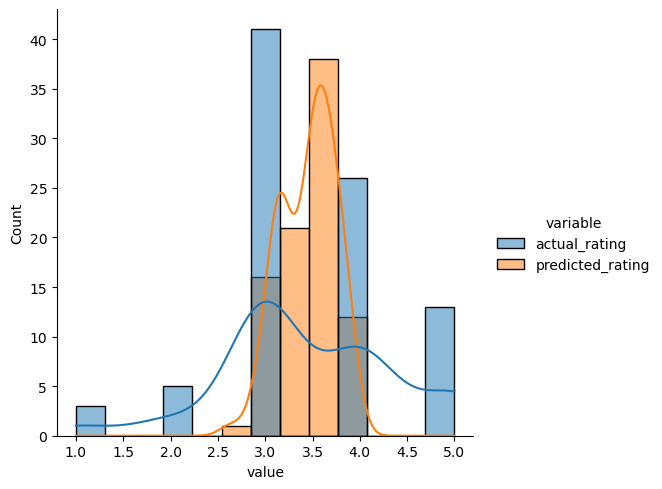

In [57]:
predicted_ratings_for_interacted_movies = predict_already_interacted_ratings(rating, 7, similarity_algo_optimized_item)
df = predicted_ratings_for_interacted_movies.melt(id_vars='movieId', value_vars=['actual_rating', 'predicted_rating'])
sns.displot(data=df, x='value', hue='variable', kde=True);

- We can see that the distribution of predicted ratings is closely following the distribution of actual ratings, it is more normalized with a mean around `3.5`. The total bins for predicted ratings are nearly same as to the total bins for actual ratings. 

- We are getting more predicted values in between 3 and 4, since the predicted ratings can have continuous values as we are taking aggregated ratings from the nearest neighbors of a given item.

- The overall predictions looks good as compared to the distribution of actual ratings.

Below we are comparing the predicted ratings by `matrix factorization based recommendation` system against actual ratings for `userId=7`

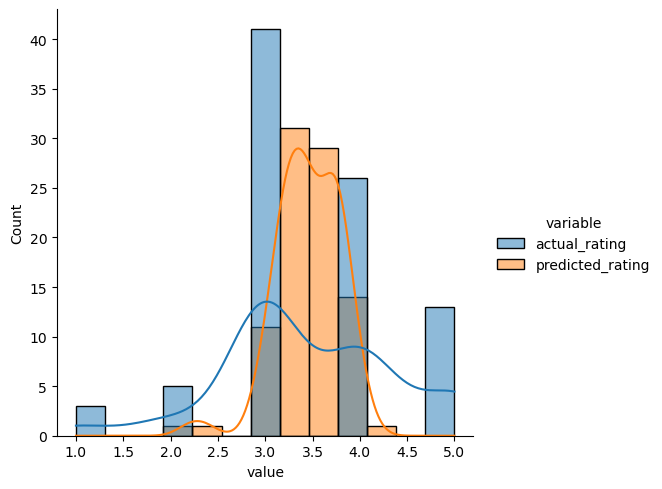

In [58]:
predicted_ratings_for_interacted_movies = predict_already_interacted_ratings(rating, 7, svd_algo_optimized)
df = predicted_ratings_for_interacted_movies.melt(id_vars='movieId', value_vars=['actual_rating', 'predicted_rating'])
sns.displot(data=df, x='value', hue='variable', kde=True);

In [59]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(0, 5))

# Loading the rating dataset
data = Dataset.load_from_df(rating[['userId', 'movieId', 'rating']], reader)

# Splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

## **Precision and Recall @ k**

RMSE is not the only metric we can use here. We can also examine two fundamental measures, precision and recall. We also add a parameter k which is helpful in understanding problems with multiple rating outputs.

### **Computing the precision and recall, for each of the 6 models, at k = 5 and 10. This is 6 x 2 = 12 numerical values?**

In [60]:
# Function can be found on surprise documentation FAQs
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls



In [61]:
# A basic cross-validation iterator.
kf = KFold(n_splits=5)

# Make list of k values
K = [5, 10]

# Make list of models
models = [algo_knn_user, similarity_algo_optimized_user,algo_knn_item,similarity_algo_optimized_item, algo_svd, svd_algo_optimized]

for k in K:
    for model in models:
        print('> k={}, model={}'.format(k,model.__class__.__name__))
        p = []
        r = []
        for trainset, testset in kf.split(data):
            model.fit(trainset)
            predictions = model.test(testset, verbose=False)
            precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=3.5)

            # Precision and recall can then be averaged over all users
            p.append(sum(prec for prec in precisions.values()) / len(precisions))
            r.append(sum(rec for rec in recalls.values()) / len(recalls))
        
        print('-----> Precision: ', round(sum(p) / len(p), 3))
        print('-----> Recall: ', round(sum(r) / len(r), 3))

> k=5, model=KNNBasic
-----> Precision:  0.771
-----> Recall:  0.414
> k=5, model=KNNBasic
-----> Precision:  0.774
-----> Recall:  0.416
> k=5, model=KNNBasic
-----> Precision:  0.608
-----> Recall:  0.325
> k=5, model=KNNBasic
-----> Precision:  0.675
-----> Recall:  0.354
> k=5, model=SVD
-----> Precision:  0.752
-----> Recall:  0.384
> k=5, model=SVD
-----> Precision:  0.747
-----> Recall:  0.382
> k=10, model=KNNBasic
-----> Precision:  0.751
-----> Recall:  0.549
> k=10, model=KNNBasic
-----> Precision:  0.755
-----> Recall:  0.562
> k=10, model=KNNBasic
-----> Precision:  0.599
-----> Recall:  0.474
> k=10, model=KNNBasic
-----> Precision:  0.653
-----> Recall:  0.502
> k=10, model=SVD
-----> Precision:  0.734
-----> Recall:  0.516
> k=10, model=SVD
-----> Precision:  0.73
-----> Recall:  0.524


### **Conclusions**

In this case study, we saw three different ways of building recommendation systems: 
- rank-based using averages
- similarity-based collaborative filtering
- model-based (matrix factorization) collaborative filtering



- The User-based and Item-based Collaborative Models are very similar in their prediction performance with `RMSE=0.99` and `RMSE=1.00` respectively.


- The tuned Collaborative Filtering Models have slightly performed better than the baseline models. The tuned Item-based Collaborative Model had a better performance with `RMSE=0.94`.


- Matrix factorization works by decomposing the user-item matrix into the product of two lower dimensionality rectangular matrices, taking into account latent variables and PC analysis to find best features to cluster on. On the other hand Collaborative Filtering searches for neighbors based on similarity of user or item, depending on type of filtering, to get preferences and recommend items that are based on nearest neighbor interactions.


- The Matrix Factorization model had the best performance with `RMSE=0.89` which was better than the optimized Item-based Collaborative Model which had a `RMSE=0.94`. Tuning the SVD matrix factorization model did not improve the base line SVD model performance by much. When comparing models using the **Recall** and **Percision** performance metrics, the tuned User-based Collaborative model had the best Recall and Percision score, this could be due to imposing a threshold on the rating of 3.5


- Matrix Factorization has lower RMSE due to the reason that it factors in latent variables for both items and users, which are present in some low dimensional space describing their properties and recommend a item based on its proximity to the user in the latent space. And so taking into account more relevant features than just the ratings.

We also understood advantages/disadvantages of these recommendation systems and when to use which kind of recommendation systems. Once we build these recommendation systems, we can use **A/B Testing** to measure the effectiveness of these systems.